<a href="https://colab.research.google.com/github/luciamartinf/BigData/blob/main/RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References

Introduction: https://www.mayoclinic.org/es-es/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=La%20neumon%C3%ADa%20es%20una%20infecci%C3%B3n,escalofr%C3%ADos%20y%20dificultad%20para%20respirar.

Code: https://www.kaggle.com/code/danushkumarv/pneumonia-detection-resnet

## Introduction


Pneumonia is an infection that inflames the air sacs of one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing coughing up phlegm or pus, fever, chills and shortness of breath. Various microorganisms, such as bacteria, viruses and fungi, can cause pneumonia.

Signs and symptoms of pneumonia vary from moderate to severe and depend on several factors, such as the type of germ that caused the infection, age and general health. Moderate signs and symptoms are often similar to those of a cold or the flu, but last longer.

Signs and symptoms of pneumonia may include the following:
- Chest pain when breathing or coughing.
- Disorientation or changes in mental perception (in adults age 65 and older)
- Cough that may produce phlegm
- Fatigue
- Fever, sweating, and shaking chills
- Lower than normal body temperature (in adults over age 65 and people with weak immune systems)
- Nausea, vomiting or diarrhea
- Shortness of breath


## Import libraries


In [1]:
import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from PIL import Image

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data paths
train_directory="/content/drive/MyDrive/Colab Notebooks/chest_xray/train/"
val_directory="/content/drive/MyDrive/Colab Notebooks/chest_xray/val/"
test_directory="/content/drive/MyDrive/Colab Notebooks/chest_xray/test/"

## Data visualization

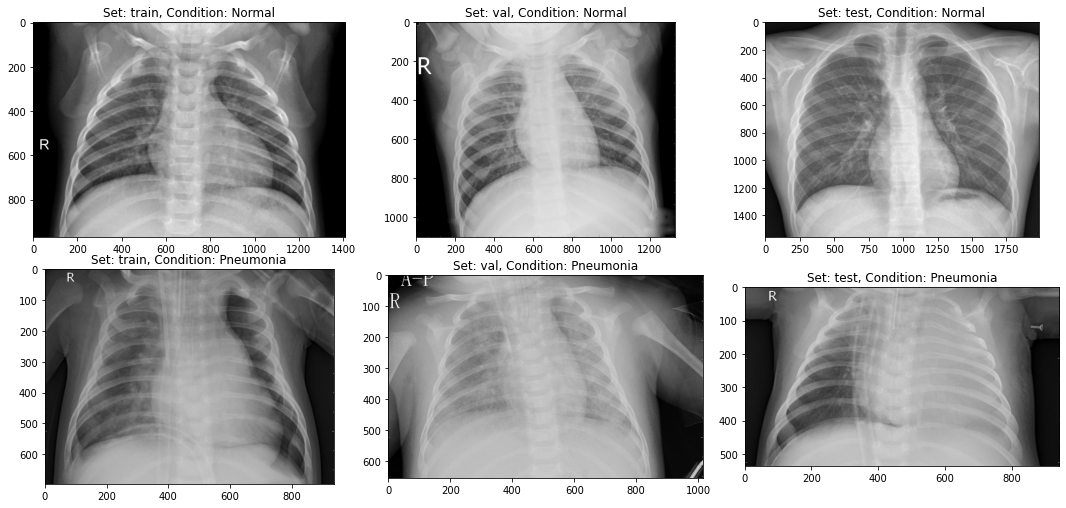

In [4]:
# Random vizualization from all directories
input_path="/content/drive/MyDrive/Colab Notebooks/chest_xray/"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

## Data pre-processing

In [5]:
# Number of images present in each set
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


In [6]:
# Fetch the dataset from the directories
# Re-sizing the images
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [7]:
# Keras ImageDataGenerator
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

Keras ImageDataGenerator: It is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data. Keras image data generator class is also used to carry out data augmentation where we aim to gain the overall increment in the generalization of the model. Operations such as rotations, translations, shearin, scale changes, and horizontal flips are carried out randomly in data augmentation using an image data generator.

In [8]:
# Flow from directory
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
img, label = next(train)

Flow from directory: This method is useful when the images are sorted and placed in there respective class/label folders. This method will identify classes automatically from the folder name.

In [10]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

Early stopping: 
In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit. Early stopping rules have been employed in many different machine learning methods, with varying amounts of theoretical foundation.

In [11]:
# ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

ReduceLROnPlateau: 
Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

## Model building (RESNET50V2)

**Deep Residual Learning for Image Recognition (CVPR 2015)**

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [12]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [13]:
res_model = create_model()

94668760/94668760 [==============================] - 0s 0us/step


In [14]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

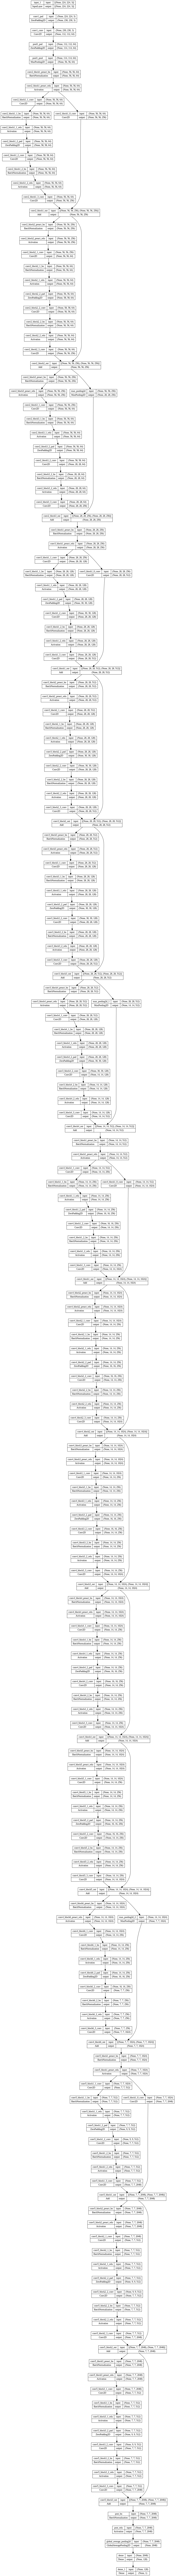

In [15]:
plot_model(res_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [16]:
history = res_model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=10,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
10/10 [==============================] - 151s 8s/step - loss: 0.6800 - accuracy: 0.7219 - val_loss: 0.6857 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 77s 7s/step - loss: 0.3304 - accuracy: 0.8625 - val_loss: 0.6756 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 76s 7s/step - loss: 0.3097 - accuracy: 0.8500 - val_loss: 1.1418 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 74s 7s/step - loss: 0.2320 - accuracy: 0.9062 - val_loss: 0.6580 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 77s 7s/step - loss: 0.2679 - accuracy: 0.8781 - val_loss: 0.9237 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 76s 7s/step - loss: 0.2950 - accuracy: 0.8719 - val_loss: 0.6212 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/30
10/10 [==============================] - 77s 8s/step - loss: 0.1634 - 

**Accuracy** **& Loss each** **epochs**

Text(0, 0.5, 'Loss')

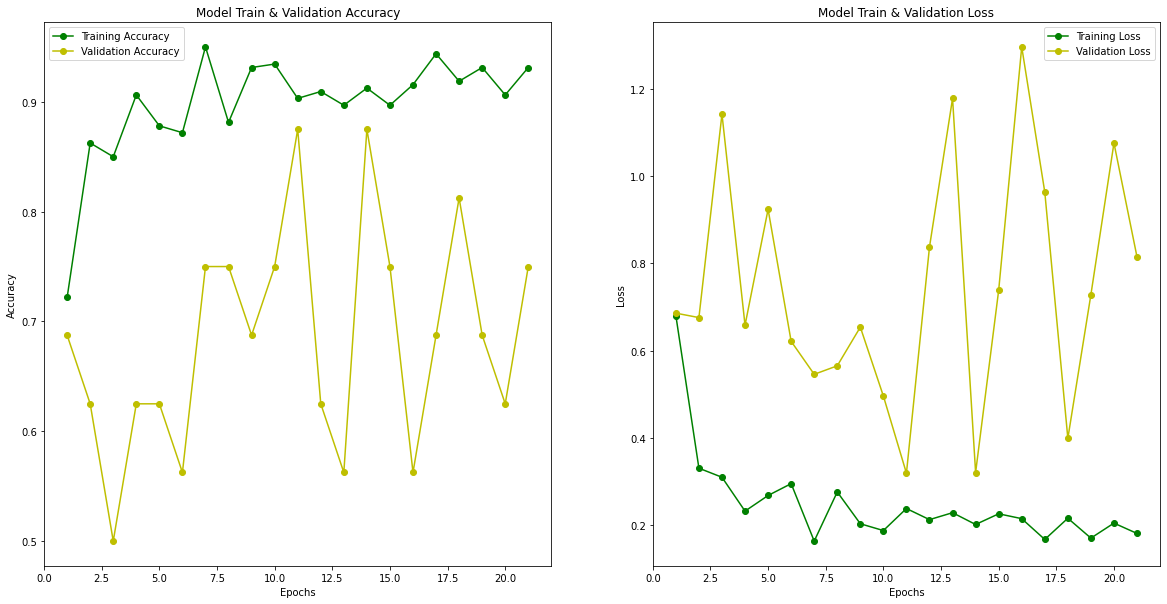

In [17]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

## Model evaluation (RESNET50V2)

In [ ]:
# Evaluating the model on train and test
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

 43/163 [======>.......................] - ETA: 14:16 - loss: 0.2026 - accuracy: 0.9193